In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Defining constant variables
DRIVE_PATH = '/content/drive/MyDrive/Bundesliga/train.csv'
POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/'
NEGATIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Negatives/'
TRAIN_SIZE = 0.75
MODEL = 'AlexNet'
# MODEL = 'LeNet-5'

In [4]:
def create_df_events():
  """Reading DataFrame and creating one with only relevant events"""
  df = pd.read_csv(DRIVE_PATH)
  df_events = df[~df['event_attributes'].isna()].copy()
  df_events.reset_index(drop=True, inplace=True)
  return df_events

In [5]:
def create_train_test_video_ids(df_events):
  """Creating two arrays with which videos are either part of the train or the test data"""
  video_ids = df_events['video_id'].unique().tolist()
  amount_videos = len(video_ids)
  amount_train = round(amount_videos * TRAIN_SIZE)
  train_videos = video_ids[:amount_train]
  test_videos = video_ids[amount_train:]
  return video_ids, train_videos, test_videos

In [6]:
def create_X(video_ids, negatives):
  """Creating X array with all pictures for both train and test data"""
  X = list()
  for video_id in video_ids:
    current_video = np.load(f'{POSITIVES_FOLDER_PATH}{video_id}.npz')
    current_video = current_video.f.arr_0
    X.append(current_video)
  if negatives:
    for video_id in video_ids[:-10]:
      current_neg_video = np.load(f'{NEGATIVES_FOLDER_PATH}{video_id}.npz')
      current_neg_video = current_neg_video.f.arr_0
      X.append(current_video)
  X = np.concatenate(X, axis=0)
  return X

In [7]:
def train_test_X_split(df_events, X, train_videos, test_videos):
  """Splitting pictures in train and test data"""
  train_idx = df_events[df_events['video_id'].isin(train_videos)].index
  test_idx = df_events[df_events['video_id'].isin(test_videos)].index
  X_train = X[train_idx]
  X_test = X[test_idx]
  assert df_events.shape[0] == X_train.shape[0] + X_test.shape[0]
  return X_train, X_test, train_idx, test_idx

In [8]:
def train_test_y_split(df_events, train_idx, test_idx):
  """Creating DataFrame of labels for both train and test data using videos ids"""
  y_train = df_events[df_events.index.isin(train_idx)]['event'].to_frame()
  y_test = df_events[df_events.index.isin(test_idx)]['event'].to_frame()
  return y_train, y_test

In [9]:
def append_negatives(df_events, X, X_train, X_test, y_train, y_test):
  """ """
  len_positives = df_events.shape[0]
  len_X = X.shape[0]
  len_negatives = len_X - len_positives

  START_IDX_NEGATIVES = df_events.shape[0]
  START_IDX_NEG_TEST = round(START_IDX_NEGATIVES + len_negatives * TRAIN_SIZE)
  X_train_neg = X[START_IDX_NEGATIVES:START_IDX_NEG_TEST]
  X_test_neg = X[START_IDX_NEG_TEST:]
  assert len_negatives == X_train_neg.shape[0] + X_test_neg.shape[0]

  X_train = np.concatenate((X_train, X_train_neg), axis=0)
  X_test = np.concatenate((X_test, X_test_neg), axis=0)

  y_train = y_train.append(pd.DataFrame({'event':['negative'] * X_train_neg.shape[0]}))
  y_train.reset_index(drop=True, inplace=True)
  y_test = y_test.append(pd.DataFrame({'event':['negative'] * X_test_neg.shape[0]}))
  return X_train, X_test, y_train, y_test

In [10]:
def create_array_to_drop_for_undersampling_in_play(y_train):
  """Creating array of indexes to drop to perform undersampling in column 'play'"""
  play_indexes = y_train[y_train['event'] == 'play'].index
  assert y_train.value_counts()['play'] == len(play_indexes)
  play_amount = y_train.value_counts()['play']
  challenge_amount = y_train.value_counts()['challenge']
  drop_play_indexes = np.sort(np.random.choice(a=play_indexes, 
                                              size=play_amount - challenge_amount, 
                                              replace=False))
  assert len(drop_play_indexes) == play_amount - challenge_amount
  return drop_play_indexes

In [11]:
def perform_undersampling(X_train, y_train, drop_play_indexes):
  """Performing undersampling in 'play' category to balance it with 'challenge'"""
  X_train = np.delete(X_train, drop_play_indexes, axis=0) # Numpy array
  y_train.drop(drop_play_indexes, axis=0, inplace=True) # Pandas DataFrame
  return X_train, y_train

In [12]:
def perform_ohe(y_train, y_test):
  """Performing one-hot-encoding on our labels"""
  current_feat = ['event']
  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
  encoder.fit(y_train[current_feat]) # Fit and transform data
  y_train[encoder.get_feature_names_out(list(current_feat))] = encoder.transform(y_train[current_feat])
  y_train = y_train.drop(columns=current_feat)

  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
  encoder.fit(y_test[current_feat]) # Fit and transform data
  y_test[encoder.get_feature_names_out(list(current_feat))] = encoder.transform(y_test[current_feat])
  y_test = y_test.drop(columns=current_feat)
  return y_train, y_test

In [13]:
def train_val_split(X_train, y_train):
  """Split train data into train and validation sets"""
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.8, random_state=0)
  return X_train, X_val, y_train, y_val

In [16]:
def del_X(X):
  """Deleting variable to free RAM"""
  del X

In [17]:
def preprocessing(negatives=True, undersampling=False, free_ram=True):
  """Run whole pipeline before building the model"""
  df_events = create_df_events()
  video_ids, train_videos, test_videos = create_train_test_video_ids(df_events)
  X = create_X(video_ids, negatives)
  X_train, X_test, train_idx, test_idx = train_test_X_split(df_events, X, train_videos, test_videos)
  y_train, y_test = train_test_y_split(df_events, train_idx, test_idx)
  if negatives:
    X_train, X_test, y_train, y_test = append_negatives(df_events, X, X_train, X_test, y_train, y_test)
  if undersampling:
    drop_play_indexes = create_array_to_drop_for_undersampling_in_play(y_train)
    X_train, y_train = perform_undersampling(X_train, y_train, drop_play_indexes)
  y_train, y_test = perform_ohe(y_train, y_test)
  X_train, X_val, y_train, y_val = train_val_split(X_train, y_train)
  if free_ram:
    del_X(X)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [18]:
def build_model(X_train):
  """ """
  input_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]

  if MODEL == 'AlexNet':
    model = Sequential([
        Rescaling(1/255, 
                  input_shape=input_shape),  

        Conv2D(filters=96, 
               kernel_size=(11, 11), 
               strides=(4, 4), 
               activation='relu'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=256, 
               kernel_size=(5, 5),
               strides=(3, 3), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=256, 
               kernel_size=(3, 3),
               strides=(1, 1), 
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Flatten(),

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(4, 
              activation='softmax')
        ])

    return model

In [19]:
# def build_model(X_train):
#   """ """
#   input_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]

#   if MODEL == 'AlexNet':

#     model = Sequential([
#         Rescaling(1/255, 
#                   input_shape=input_shape),   
#         Conv2D(filters=96, 
#               kernel_size=(11, 11), 
#               strides=(4, 4), 
#               activation='relu'),
#         MaxPooling2D(pool_size=3, 
#                     strides=2),
#         Conv2D(256, 
#               5, 
#               activation='relu'),
#         MaxPooling2D(pool_size=3, 
#                     strides=2),
#         Conv2D(384, 
#               3, 
#               activation='relu'),
#         Conv2D(384, 
#               3, 
#               activation='relu'),
#         Conv2D(256, 
#               3, 
#               activation='relu'),
#         MaxPooling2D(),
#         Flatten(),
#         Dense(256, 
#               activation='relu'),
#         Dense(256, 
#               activation='relu'),
#         Dense(4, 
#               activation='softmax')
#     ])

#   elif MODEL == 'LeNet-5' and input_shape[:-1] == (480, 640):
#     model = Sequential([
#         Rescaling(1/255, 
#                   input_shape=input_shape),   
#         Conv2D(6, # input 480, output 480
#               5, 
#               strides=1, 
#               activation='tanh'),
#         AveragePooling2D(pool_size=2, # input 480, output 240
#                          strides=2),
#         Conv2D(16, 
#               5, 
#               activation='tanh'), # input 240, output 236
#         AveragePooling2D(pool_size=2, 
#                          strides=2), # input 236, output 118
#         Conv2D(120, 
#               5, 
#               activation='tanh'), # input 118, output 114



#         # AveragePooling2D(pool_size=6, 
#         #                  strides=6), # input 114, output 19
#         # Conv2D(120, 
#         #       5, 
#         #       activation='tanh'), # input 19, output 15
#         # AveragePooling2D(pool_size=7, 
#         #                  strides=2), # input 15, output 5
#         # Conv2D(120, 
#         #       5, 
#         #       activation='tanh'), # input 5, output 1
#         Flatten(),
#         Dense(256, 
#               activation='relu'),
#         # Dense(256, 
#         #       activation='relu'),
#         Dense(4, 
#               activation='softmax')
#     ])

#   return model

In [20]:
def compile_model(model):
  """ """
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy',
              )
  return model

In [21]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, validation_split=0.2, batch_size=16, patience=3):
  """ """
  callback = EarlyStopping(monitor='val_loss',
                         patience=patience,
                         restore_best_weights=True
                         )

  model.fit(X_train, 
            y_train, 
            validation_data=(X_val, y_val), 
            batch_size=batch_size, 
            epochs=epochs,
            callbacks=[callback])
  
  return model

## Building 2nd baseline model - with negatives and without undersampling

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing()

In [23]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3188, 480, 640, 3),
 (797, 480, 640, 3),
 (1169, 480, 640, 3),
 (3188, 4),
 (797, 4),
 (1169, 4))

In [24]:
model = build_model(X_train)
model = compile_model(model)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 480, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization (BatchN  (None, 118, 158, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 78, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 20, 26, 256)      1

In [26]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
200/200 [==============================] - 267s 1s/step - loss: 0.8539 - accuracy: 0.7582 - val_loss: 0.6565 - val_accuracy: 0.7691
Epoch 2/100
200/200 [==============================] - 273s 1s/step - loss: 0.5773 - accuracy: 0.8259 - val_loss: 0.5988 - val_accuracy: 0.7992
Epoch 3/100
200/200 [==============================] - 264s 1s/step - loss: 0.5380 - accuracy: 0.8385 - val_loss: 0.5365 - val_accuracy: 0.8356
Epoch 4/100
200/200 [==============================] - 269s 1s/step - loss: 0.5197 - accuracy: 0.8441 - val_loss: 0.6867 - val_accuracy: 0.7754
Epoch 5/100
200/200 [==============================] - 270s 1s/step - loss: 0.5240 - accuracy: 0.8394 - val_loss: 0.5158 - val_accuracy: 0.8407
Epoch 6/100
200/200 [==============================] - 272s 1s/step - loss: 0.5182 - accuracy: 0.8397 - val_loss: 0.4861 - val_accuracy: 0.8407
Epoch 7/100
200/200 [==============================] - 263s 1s/step - loss: 0.4842 - accuracy: 0.8450 - val_loss: 0.5073 - val_accuracy:

In [27]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              2234
                 1.0             0.0         0.0               464
1.0              0.0             0.0         0.0               402
0.0              0.0             0.0         1.0                88
dtype: int64

In [28]:
y_test.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              797
                 1.0             0.0         0.0              193
1.0              0.0             0.0         0.0              119
0.0              0.0             0.0         1.0               60
dtype: int64

In [29]:
y_test

,event_challenge,event_negative,event_play,event_throwin
3406,0.0,0.0,1.0,0.0
3407,0.0,0.0,1.0,0.0
3408,0.0,0.0,1.0,0.0
3409,0.0,0.0,1.0,0.0
3410,0.0,0.0,1.0,0.0
...,...,...,...,...
188,0.0,1.0,0.0,0.0
189,0.0,1.0,0.0,0.0
190,0.0,1.0,0.0,0.0
191,0.0,1.0,0.0,0.0


In [30]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

37/37 [==============================] - 22s 590ms/step - loss: 5.6115 - accuracy: 0.5706

Accuracy on the test set: 0.5706


In [72]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_train, y_train)[INDEX_ACCURACY]:.4f}')

100/100 [==============================] - 55s 553ms/step - loss: 0.4609 - accuracy: 0.8457

Accuracy on the test set: 0.8457


In [94]:
new_y_train = y_train.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [93]:
y_pred_train = model.predict(X_train)

100/100 [==============================] - 57s 574ms/step


In [96]:
y_pred_train_b = [np.argmax(i, axis=0) for i in y_pred_train]

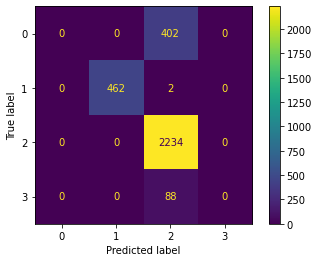

In [97]:
ConfusionMatrixDisplay.from_predictions(new_y_train, y_pred_train_b)
plt.show()

In [71]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test[-600:-550], y_test.iloc[-600:-550])[INDEX_ACCURACY]:.4f}')

2/2 [==============================] - 1s 406ms/step - loss: 11.2187 - accuracy: 0.3000

Accuracy on the test set: 0.3000


In [31]:
np.set_printoptions(suppress=True)

In [34]:
y_test

,event_challenge,event_negative,event_play,event_throwin
3406,0.0,0.0,1.0,0.0
3407,0.0,0.0,1.0,0.0
3408,0.0,0.0,1.0,0.0
3409,0.0,0.0,1.0,0.0
3410,0.0,0.0,1.0,0.0
...,...,...,...,...
188,0.0,1.0,0.0,0.0
189,0.0,1.0,0.0,0.0
190,0.0,1.0,0.0,0.0
191,0.0,1.0,0.0,0.0


In [32]:
y_pred = model.predict(X_test)
y_pred

37/37 [==============================] - 21s 552ms/step


array([[0.24396832, 0.00132348, 0.65313464, 0.10157349],
       [0.24241799, 0.00090088, 0.66107225, 0.09560883],
       [0.23714446, 0.0020777 , 0.65617394, 0.10460388],
       ...,
       [0.0000006 , 0.9999986 , 0.00000073, 0.00000001],
       [0.00000006, 0.9999997 , 0.00000006, 0.        ],
       [0.00000028, 0.9999995 , 0.0000003 , 0.        ]], dtype=float32)

In [46]:
y_pred_b = [np.argmax(i, axis=0) for i in y_pred]

In [51]:
y_test

,event_challenge,event_negative,event_play,event_throwin
3406,0.0,0.0,1.0,0.0
3407,0.0,0.0,1.0,0.0
3408,0.0,0.0,1.0,0.0
3409,0.0,0.0,1.0,0.0
3410,0.0,0.0,1.0,0.0
...,...,...,...,...
188,0.0,1.0,0.0,0.0
189,0.0,1.0,0.0,0.0
190,0.0,1.0,0.0,0.0
191,0.0,1.0,0.0,0.0


In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [52]:
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred_b)
# plt.show()

In [33]:
y_train['event_negative'].value_counts()[1] + y_val['event_negative'].value_counts()[1]

579

In [57]:
y_pred[-580:-500]

array([[0.19059621, 0.00109657, 0.7675906 , 0.04071658],
       [0.00001251, 0.9997809 , 0.00016004, 0.00004656],
       [0.00000494, 0.99991435, 0.00005555, 0.00002518],
       [0.00000146, 0.9999699 , 0.00002098, 0.00000768],
       [0.00000009, 0.9999971 , 0.00000223, 0.00000051],
       [0.00000283, 0.999934  , 0.00005179, 0.00001137],
       [0.        , 0.9999998 , 0.00000011, 0.00000003],
       [0.        , 0.9999998 , 0.0000001 , 0.00000003],
       [0.00000001, 0.9999998 , 0.00000016, 0.00000006],
       [0.00000002, 0.99999934, 0.00000049, 0.00000018],
       [0.        , 0.9999998 , 0.00000013, 0.00000004],
       [0.00000006, 0.99999803, 0.0000013 , 0.00000043],
       [0.00000003, 0.9999991 , 0.00000065, 0.0000002 ],
       [0.00000001, 0.9999997 , 0.00000018, 0.00000006],
       [0.00000003, 0.9999991 , 0.00000059, 0.0000002 ],
       [0.00000007, 0.99999803, 0.00000129, 0.00000049],
       [0.00000003, 0.999999  , 0.00000068, 0.00000024],
       [0.00000006, 0.9999983 ,

In [45]:
INDEX_PLAY = 2
print(f"Checking if the model always predicts 'play' (majority class): \n"
      f"{(np.argmax(y_pred, axis=1) == INDEX_PLAY).all()}")

Checking if the model always predicts 'play' (majority class): 
False


In [36]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [37]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

In [97]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

## Building 3rd baseline model - with negatives and undersampling

In [98]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(undersampling=True)

In [101]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1360, 480, 640, 3),
 (341, 480, 640, 3),
 (1169, 480, 640, 3),
 (1360, 4),
 (341, 4),
 (1169, 4))

In [99]:
model = build_model(X_train)
model = compile_model(model)

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_5 (Batc  (None, 118, 158, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 78, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 20, 26, 256)     

In [ ]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
 7/85 [=>............................] - ETA: 1:41 - loss: 2.9492 - accuracy: 0.3125

In [71]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              1.0             0.0         0.0              579
                 0.0             1.0         0.0              505
1.0              0.0             0.0         0.0              505
0.0              0.0             0.0         1.0              112
dtype: int64

In [74]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model3.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

37/37 [==============================] - 20s 546ms/step - loss: 7.4709 - accuracy: 0.5227

Accuracy on the test set: 0.5227


In [75]:
y_pred = model.predict(X_test)
y_pred

37/37 [==============================] - 20s 546ms/step


array([[4.3712151e-01, 3.2359766e-04, 4.7913864e-01, 8.3416209e-02],
       [4.3358871e-01, 2.6745157e-04, 4.8547813e-01, 8.0665708e-02],
       [4.3801990e-01, 5.7913049e-04, 4.5852530e-01, 1.0287565e-01],
       ...,
       [6.3997585e-11, 9.9999994e-01, 1.2344538e-11, 9.7481988e-11],
       [3.9952843e-11, 9.9999994e-01, 7.5053271e-12, 6.1375779e-11],
       [2.4447189e-07, 9.9999940e-01, 1.1566087e-07, 2.5286280e-07]],
      dtype=float32)

In [ ]:
INDEX_PLAY = 2
print(f"Checking if the model always predicts 'play' (majority class): \n"
      f"{(np.argmax(y_pred, axis=1) == INDEX_PLAY).all()}")

In [ ]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_3')

In [4]:
# df = pd.read_csv(DRIVE_PATH)
# df_events = df[~df['event_attributes'].isna()].copy()
# df_events.reset_index(drop=True, inplace=True)

In [5]:
# video_ids = df_events['video_id'].unique().tolist()
# amount_videos = len(video_ids)
# amount_train = round(amount_videos * TRAIN_SIZE)
# train_videos = video_ids[:amount_train]
# test_videos = video_ids[amount_train:]

In [6]:
# video_ids

['1606b0e6_0',
 '1606b0e6_1',
 '35bd9041_0',
 '35bd9041_1',
 '3c993bd2_0',
 '3c993bd2_1',
 '407c5a9e_1',
 '4ffd5986_0',
 '9a97dae4_1',
 'cfbe2e94_0',
 'cfbe2e94_1',
 'ecf251d4_0']

In [7]:
# X = None
# for video_id in video_ids:
#   if X is None:
#     current_video = np.load(f'{POSITIVES_FOLDER_PATH}{video_id}.npz')
#     X = current_video.f.arr_0
#   else:
#     current_video = np.load(f'{POSITIVES_FOLDER_PATH}{video_id}.npz')
#     current_video = current_video.f.arr_0
#     X = np.concatenate([X, current_video], axis=0)

# len_positives = 0
# for i in X:
#   len_positives += i.shape[0]


# if NEGATIVES:
#   for video_id in video_ids[:-9]:
#     current_neg_video = np.load(f'{NEGATIVES_FOLDER_PATH}{video_id}.npz')
#     current_neg_video = current_neg_video.f.arr_0
#     X = np.concatenate([X, current_video], axis=0)

In [28]:
# X = list()
# for video_id in video_ids:
#   current_video = np.load(f'{POSITIVES_FOLDER_PATH}{video_id}.npz')
#   current_video = current_video.f.arr_0
#   X.append(current_video)
# if NEGATIVES:
#   for video_id in video_ids[:-10]:
#     current_neg_video = np.load(f'{NEGATIVES_FOLDER_PATH}{video_id}.npz')
#     current_neg_video = current_neg_video.f.arr_0
#     X.append(current_video)
# X = np.concatenate(X, axis=0)

In [ ]:
# train_idx = df_events[df_events['video_id'].isin(train_videos)].index
# test_idx = df_events[df_events['video_id'].isin(test_videos)].index
# X_train = X[train_idx]
# X_test = X[test_idx]
# assert df_events.shape[0] == X_train.shape[0] + X_test.shape[0]

# y_train = df_events[df_events.index.isin(train_idx) ]['event'].to_frame()
# y_test = df_events[df_events.index.isin(test_idx) ]['event'].to_frame()



# len_positives = df_events.shape[0]
# len_X = X.shape[0]
# len_negatives = len_X - len_positives

# START_IDX_NEGATIVES = df_events.shape[0]
# START_IDX_NEG_TEST = round(START_IDX_NEGATIVES + len_negatives * TRAIN_SIZE)
# X_train_neg = X[START_IDX_NEGATIVES:START_IDX_NEG_TEST]
# X_test_neg = X[START_IDX_NEG_TEST:]
# assert len_negatives == X_train_neg.shape[0] + X_test_neg.shape[0]

# X_train = np.concatenate((X_train, X_train_neg), axis=0)
# X_test = np.concatenate((X_test, X_test_neg), axis=0)

# y_train = y_train.append(pd.DataFrame({'event':['negative'] * X_train_neg.shape[0]}))
# y_test = y_test.append(pd.DataFrame({'event':['negative'] * X_test_neg.shape[0]}))

In [29]:
# len_positives = df_events.shape[0]
# len_positives

4382

In [30]:
# len_X = X.shape[0]
# len_negatives = len_X - len_positives
# len_negatives

772

In [31]:
# df_events['event'].value_counts()

play         3586
challenge     624
throwin       172
Name: event, dtype: int64

In [32]:
# train_idx = df_events[df_events['video_id'].isin(train_videos)].index
# test_idx = df_events[df_events['video_id'].isin(test_videos)].index
# X_train = X[train_idx]
# X_test = X[test_idx]
# assert df_events.shape[0] == X_train.shape[0] + X_test.shape[0]

In [33]:
# y_train = df_events[df_events.index.isin(train_idx) ]['event'].to_frame()
# y_test = df_events[df_events.index.isin(test_idx) ]['event'].to_frame()

In [34]:
# X.shape

(5154, 480, 640, 3)

In [35]:
# X_train.shape, X_test.shape

((3406, 480, 640, 3), (976, 480, 640, 3))

In [36]:
# START_IDX_NEGATIVES = df_events.shape[0]
# START_IDX_NEGATIVES

4382

In [37]:
# START_IDX_NEG_TEST = round(START_IDX_NEGATIVES + len_negatives * TRAIN_SIZE)
# START_IDX_NEG_TEST

4961

In [38]:
# X_train_neg = X[START_IDX_NEGATIVES:START_IDX_NEG_TEST]
# X_test_neg = X[START_IDX_NEG_TEST:]

In [58]:
# X_train_neg.shape[0], X_test_neg.shape[0]

(579, 193)

In [39]:
# assert len_negatives == X_train_neg.shape[0] + X_test_neg.shape[0]

In [40]:
# del X

In [41]:
# X_train = np.concatenate((X_train, X_train_neg), axis=0)
# X_train.shape

(3985, 480, 640, 3)

In [42]:
# X_test = np.concatenate((X_test, X_test_neg), axis=0)
# X_test.shape

(1169, 480, 640, 3)

In [48]:
# 772*0.75

579.0

In [47]:
# y_train

,event
0,challenge
1,challenge
2,throwin
3,play
4,play
...,...
3401,challenge
3402,play
3403,challenge
3404,challenge


In [59]:
# y_train = y_train.append(pd.DataFrame({'event':['negative'] * X_train_neg.shape[0]}))
# y_test = y_test.append(pd.DataFrame({'event':['negative'] * X_test_neg.shape[0]}))

In [ ]:
input_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]

model = Sequential([
    Rescaling(1/255, 
              input_shape=input_shape),   
    Conv2D(96, 
           11, 
           strides=4, 
           activation='relu'),
    MaxPooling2D(pool_size=3, 
                 strides=2),
    Conv2D(256, 
           5, 
           activation='relu'),
    MaxPooling2D(pool_size=3, 
                 strides=2),
    Conv2D(384, 
           3, 
           activation='relu'),
    Conv2D(384, 
           3, 
           activation='relu'),
    Conv2D(256, 
           3, 
           activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, 
          activation='relu'),
    Dense(256, 
          activation='relu'),
    Dense(3, 
          activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy',
              )

In [ ]:
callback = EarlyStopping(monitor='val_loss',
                         patience=3,
                         restore_best_weights=True
                         )

In [ ]:
EPOCHS = 100
model.fit(X_train, 
          y_train, 
          validation_split=0.2, 
          batch_size=16, 
          epochs=EPOCHS,
          callbacks=[callback])

In [ ]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

In [ ]:
y_pred = model.predict(X_test)
np.set_printoptions(threshold=sys.maxsize)
print(y_pred)